# SMOKES INFORMATION PER MAP
This part of the notebook explores the smoke grenade explosions in each map for each side. In this notebook, we will do clustering using Density-Based Spatial Clustering of Applications with Noise (DBSCAN) algorithm, which is density based. The selection for algorithm is maninly influenced by a research article by Amiruzzaman et al. (2022), which stated that DBSCAN is mainly used in clustering geographical data, which is essentially what we are dealing with in this part of the notebook. After this, we do association rule mining by creating baskets of smokes within 512 ticks or 8 seconds of each other as the antecedents and win as the consequent. We filter for the baskets with winning consequent. Then, we do significance testing of the extracted rules using chi square test of independence on the wins/losses with/without the smoke/s. 

The main reason we do all these statistical analysis is to be able to determine which smoke setups are associated with wins. Having this info can go two ways: You can either implement the smoke setups we mined, or you can prepare to counter the setups done if you are on the opposing team. Keep in mind that this is just association with wins and not a true causation. Just because you threw a smoke on the cluster or setup that is associated with a win, it does not mean you automatically boost your win rate.

We also wanted to explore on smoke grenades data since it is one of the core strategies/game mechanics of this game or even by the genre of First Person Shooting (FPS) games. 

To start we load all the following libraries

In [13]:
import pandas as pd
from pandas import DataFrame
import numpy as np

from demoparser2 import DemoParser

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from kneed import KneeLocator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from scipy.stats import chi2_contingency



This is essentially the starting DataFrame, most info that will undergo the statistical analysis of this notebook is read from this csv. We also do analysis per side (Terrorist or Counter-terrorist) per map, since there can be a different smoke setup for each side for each map

In [14]:
# MAP_NAME = strings of maps (de_ancient, de_mirage, de_inferno, de_overpass, de_nuke, de_vertigo)
# side = 'T' or 'CT' (team name)
def smoke_df(MAP_NAME, side):
    df = pd.read_csv("smokes.csv")  # contains all smokes data
    main_df = df.loc[df['map_name'] == MAP_NAME]
    t_smokes_df = main_df.loc[main_df['team_name'] == side]

    return t_smokes_df

As mentioned, DBSCAN is used for clustering. We decided to do a 3D clustering since maps in CS2 have elevations, and some maps have multi-level areas/buildings. The epsilon we used is based on the actual radius of the smoke of smoke_grenade in CS2. On the other hand, the min_samples is based on the convention of dimensions of data multiplied by 2 (in this case 3*2).

In [15]:
# How to use: this function takes coordinates from df input and runs DBSCAN clustering on them.
# It returns the df with a new column 'cluster' that contains the cluster labels.
# It assigns a value of -1 if it is considered as noise by DBSCAN.
def smoke_clustering_dbscan(df):
    # Extract coordinates from the DataFrame
    coords = df[['x', 'y', 'z']].values

    # DBSCAN clustering
    smoke_radius = 150
    dimensions = 3 # 3D coordinates (x, y, z)
    convention = dimensions * 2 # Standard convention for min_samples in DBSCAN
    temp = DBSCAN(eps=smoke_radius, min_samples=convention).fit(coords)
    
    # Assign labels to the DataFrame
    df['cluster'] = temp.labels_
    return df




In [16]:
# Function for visualizing the 3D clusters in 2D (topview)
def plot_smoke_clusters_in_2d(main_df):
    offset = 100  # Offset for text labels to avoid overlap with points
    plt.figure(figsize=(10, 8))
    
    for label in sorted(main_df['cluster'].unique()):
        cluster_df = main_df[main_df['cluster'] == label]
        color = 'k' if label == -1 else None
        
        # Plot points
        plt.scatter(cluster_df['x'], cluster_df['y'], label=f'Cluster {label}', s=40, alpha=0.7, edgecolors='w', c=color)
        
        # Add label at centroid for each cluster
        if label != -1:
            cx = cluster_df['x'].mean() - offset
            cy = cluster_df['y'].mean() - offset
            plt.text(cx, cy, str(label), fontsize=12, weight='bold',
                        ha='center', va='center', color='black',
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.xlabel("X (map units)")
    plt.ylabel("Y (map units)")
    plt.title("Top-Down 2D View of 3D Smoke Clusters")
    plt.grid(True)
    plt.axis("equal")
    plt.show()

In [17]:
# To be used for inference test later so that we can get the wins/losses of without the smokes
def get_round_wins_df(map_name: str, side: str):

    main_stats_df = pd.read_csv("demos.csv")

    # Filter based on side
    if side == 'T':
        main_stats_df['is_T'] = (main_stats_df['round_ct_team'] != main_stats_df['team_name'])
        main_stats_df = main_stats_df[main_stats_df['is_T']]
    else:
        main_stats_df['is_CT'] = (main_stats_df['round_ct_team'] == main_stats_df['team_name'])
        main_stats_df = main_stats_df[main_stats_df['is_CT']]

    main_stats_df['is_win'] = (main_stats_df['round_result'] == 'CT') & (main_stats_df['round_ct_team'] == main_stats_df['team_name']) | (main_stats_df['round_result'] == 'T') & (main_stats_df['round_ct_team'] != main_stats_df['team_name'])
    round_wins = main_stats_df.drop_duplicates(subset=['team_name', 'round_id', 'is_win'])

    round_wins = round_wins[['team_name', 'round_id', 'match_id', 'map_id','round_number', 'is_win', 'map_name']]

    # Filter based on map_name
    wins_df = round_wins[round_wins['map_name'] == map_name]
  
    return wins_df


### Basket Creation

The thought process for this is that I wanted to go through each smokes in the round and create a basket of smokes that are within 512 ticks of each other.
If a smoke is detected to be near another, it will be appended to the same basket, and not be used again in the same round
I wanted to make it a DataFrame because it is easier to manipulate later on. The antecedents for this are the smoke setups while the consequent is win/loss


In [18]:

def create_baskets_df(main_df: DataFrame):
    # Filter and sort
    sorted_df = main_df.sort_values(by=['mapid', 'matchid', 'round_number', 'round_tick'])

    basket_rows = []

    # We dont have round_id so we make use of whats available :)
    for (mapid, matchid, round_number), round_df in sorted_df.groupby(['mapid', 'matchid', 'round_number']):
        round_df = round_df.reset_index(drop=True)
        used_indices = set()
        # For every instance of a smoke in the round loop
        for i in range(len(round_df)):
            # Ensure we dont reprocess already used smokes and have dupes
            if i in used_indices:
                continue 

            base_tick = round_df.loc[i, 'round_tick']
            win_label = 'win' if round_df.loc[i, 'is_win'] else 'loss'

            # Select smokes within the 512-tick window
            in_window = (round_df['round_tick'] >= base_tick) & (round_df['round_tick'] <= base_tick + 512)
            unused = ~round_df.index.isin(used_indices)
            basket_df = round_df[in_window & unused]

            # If we have smokes in the basket, we create a row
            if not basket_df.empty:
                clusters = basket_df['cluster'].unique().tolist()
                antecedent = [str(c) for c in clusters]
                

                basket_rows.append({
                    'map_id': mapid,
                    'match_id': matchid,
                    'round_number': round_number,
                    'antecedent': antecedent,
                    'win_label': win_label
                })

                used_indices.update(basket_df.index)

    return pd.DataFrame(basket_rows)

# Since the round_id is not available in the smoke data, we need to append it.
def append_round_id_to_baskets_df(baskets_df: DataFrame, round_wins_df: DataFrame):
    # Merge the baskets DataFrame with the round wins DataFrame to get the round_id
    merged_df = pd.merge(baskets_df, round_wins_df[['match_id','map_id', 'round_number','round_id']],
                         on=['map_id', 'match_id', 'round_number'], how='inner')

    return merged_df[['round_id', 'antecedent', 'win_label']]

# This is because the ARM function we use needs a list of baskets or a list of lists
def baskets_df_to_list(baskets_df: DataFrame):
    basket_list = []
    for _, row in baskets_df.iterrows():
        basket = row['antecedent'] + [row['win_label']]
        basket_list.append(basket)
    return basket_list


## Association Rule Mining
We already did clustering, but we believe we can go deeper and do association rule mining with the smoke setups as the antecedent, and the round win as the consequent. We define smoke setups as thrown smoke grenades in the clusters formed by the clustering algorithm. Furthermore, we decided to group smokes that were thrown 8 seconds from each other as a single smoke setup. For example, if a smoke grenade is thrown in cluster 12, and there is no other smokes thrown within 8 seconds for all clusters, then we treat that smoke setup as a basket of [12]. If there is a smoke grenade thrown in cluster 1, and after 5 seconds, another one is thrown in cluster 4, then we classify that as a basket of [1,4]. 

This way, we can know which smoke setup is associated with winning, given the parameters below.

As we know, Association Rule Mining needs two parameters, the minimum support and confidence. The min_support I used is based on a cluster average on the smokes that are not part of the noise. The confidence is at 55% since this would mean that the smoke rules/setup wins at least 55% of the rounds it is used. 

In [19]:
# min_support calculation function
def get_min_support (main_df: DataFrame):
    
    cluster_count = main_df['cluster'].unique().shape[0]
    total_smokes = main_df.shape[0]
    noise_smokes = main_df[main_df['cluster'] == -1].shape[0]
    ratio = (total_smokes - noise_smokes) / total_smokes

    min_support = ratio / cluster_count
    return min_support

def association_rule_mining(baskets: list, min_support: float):
    # Special thanks to https://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/ and 
    # https://www.geeksforgeeks.org/machine-learning/implementing-apriori-algorithm-in-python/ for the guide on ARM
    te = TransactionEncoder()
    te_ary = te.fit(baskets).transform(baskets)
    basket_df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = apriori(basket_df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.55)

    # Filtering for rules where 'win' is the consequence
    win_rules = rules[rules['consequents'] == {'win'}]

    # Display the top rules
    print(win_rules[['antecedents', 'consequents', 'support', 'confidence']])
    return win_rules
    

## Significance Testing
After we determine the rules, we would want to test whether the association is purely by chance, or the association is statistically significant. 

We define our null hypothesis as:
"The smoke setup/s do not have an impact towards winning the round."

And we set our confidence level to 95%. 

We test this using chi-square test of independence, with the contingency table being formed with the categories of win/loss and with/without smoke setup. The reason we chose chi-square test of independence is due to the fact that the data we are dealing with are categorical.

In [20]:
# For convenience, since the antecedent in the DataFrame is in frozenset data type
def convert_basket_to_string(basket: list):
    return ', '.join(map(str, basket))

# Merging the antecedent column with the wins DataFrame
# We do this because we will need to know the win/loss status of all rounds, not just the ones with smokes/antecedents
def get_antecedent_column(baskets_df: DataFrame, wins_df: DataFrame):
    baskets_df.rename(columns={'win_label' : 'is_win'}, inplace=True)

    contingency_df = pd.merge(wins_df[['round_id', 'is_win']], baskets_df[['antecedent', 'round_id']], on=['round_id'], how='left')
    contingency_df['antecedent'] = contingency_df['antecedent'].apply(lambda x: convert_basket_to_string(x) if isinstance(x, list) else x)
    return contingency_df

In [21]:
# Helper funcs

# Just to sort
def format_antecedent(ant):
    return ', '.join(sorted(ant))

# This basically makes antecedents to be in a form of {1,2} instead of '1, 2'
def make_set(ant):
    return set(map(str.strip, ant.split(','))) if ant.strip() else set()

"""
My thought proceess fot this is to to "compress" each round since each round can have multiple antecedents.
This way we can have a single row per round with a list of antecedents. Of course we really cant just append the antecedents
to each other, that will not model how the baskets work. Thats why I opted to use a list of sets, where the
sets are the antecedents for each round. This way we can still check if a rule is a subset of any antecedent in the round.
I asked ChatGPT to help me with in understanding how to to be able to use list of sets 
"""
def get_contingency_table_df_from_arm(df: DataFrame, win_rules_df : DataFrame):
    # Convert each antecedent string into a set of strings
    df['antecedent'] = df['antecedent'].fillna('').astype(str)
    df['antecedent'] = df['antecedent'].apply(
        lambda x: make_set(x) 
    )

    # Group by round_id and collect list of sets (which are seperated based on the antecedent)
    grouped = df.groupby('round_id').agg({
        'is_win': 'first',
        'antecedent': lambda x: list(x) # This basically in a form of [{1,2}, {0}] because we don't want to just append the antecedents, that would generate unwanted combinations 
        
    }).reset_index()

    data = []

    for _, rule_row in win_rules_df.iterrows():
        rule_set = set(rule_row['antecedents']) 
        rule_str = format_antecedent(rule_set)

        # Check if rule_set is subset of any itemset in the round, ChatGPT helped me with the function of the lambda here
        has_rule = grouped['antecedent'].apply(
            lambda ant_list: any(rule_set.issubset(ant) for ant in ant_list)
        )

        with_rule_df = grouped[has_rule]
        
        no_rule_df = grouped[~has_rule]

        # Collecting the data for the contingency table
        data.append({
            'antecedent': rule_str,
            'win_with_rule': (with_rule_df['is_win'] == True).sum(),
            'loss_with_rule': (with_rule_df['is_win'] == False).sum(),
            'win_without_rule': (no_rule_df['is_win'] == True).sum(),
            'loss_without_rule': (no_rule_df['is_win'] == False).sum()
        })

    return pd.DataFrame(data)


In [22]:
# The previous function is not really the contingency table, it is more of a container for the wins/losses, which is needed for the actual contingency table
def get_chi_squared_test(contingency_df):
    for i, row in contingency_df.iterrows():
        contingency = [
            [row['win_with_rule'], row['loss_with_rule']],
            [row['win_without_rule'], row['loss_without_rule']]
        ]
        chi2, p, dof, expected = chi2_contingency(contingency, correction=False)
        print(f"Antecedent: {{{row['antecedent']}}} p = {p:.4f}")


In [23]:
# Main function to call all the functions before
# We do analysis for a specific map and side (T or CT)
def main_func(MAP_NAME, SIDE): 
    main_df = smoke_df(MAP_NAME, SIDE)
    main_df = smoke_clustering_dbscan(main_df)


    plot_smoke_clusters_in_2d(main_df)

    filtered_main_df = main_df[main_df['cluster'] != -1]  # Filter out noise clusters
    baskets = create_baskets_df(filtered_main_df) 
    win_df = get_round_wins_df(MAP_NAME, SIDE)
    baskets = append_round_id_to_baskets_df(baskets, win_df)

    baskets_list = baskets_df_to_list(baskets)

    support = get_min_support(main_df)
    win_rules = association_rule_mining(baskets_list, support)

    temp = get_antecedent_column(baskets, win_df)
    temp2 = get_contingency_table_df_from_arm(temp, win_rules)
    get_chi_squared_test(temp2)



## DE_ANCIENT
### Terrorist Side

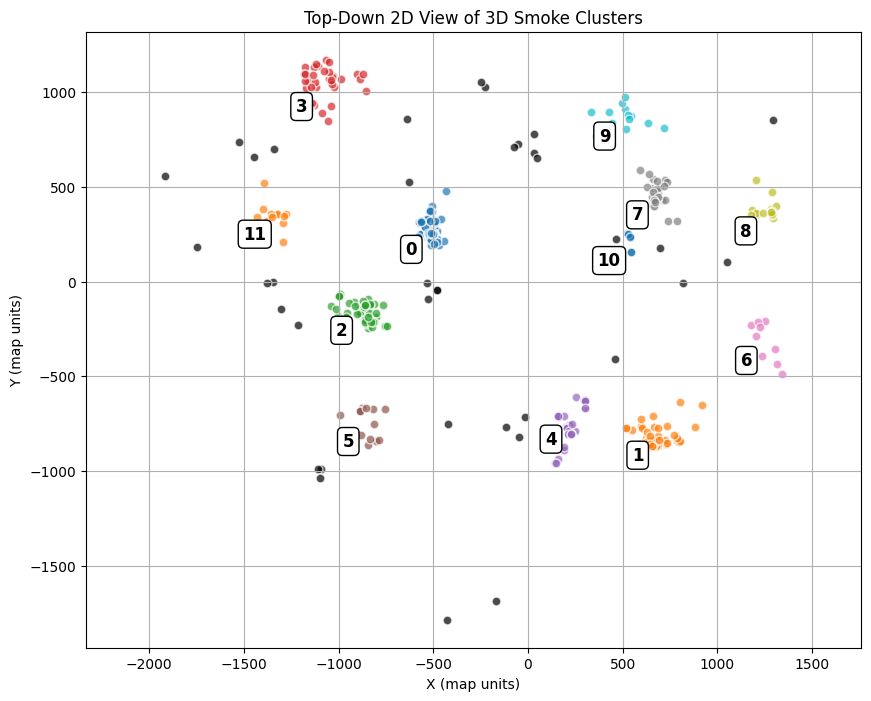

   antecedents consequents   support  confidence
2          (0)       (win)  0.269504    0.603175
3          (1)       (win)  0.095745    0.574468
4          (2)       (win)  0.120567    0.653846
5          (4)       (win)  0.113475    0.571429
6          (7)       (win)  0.092199    0.634146
8       (1, 0)       (win)  0.078014    0.594595
11      (4, 0)       (win)  0.095745    0.562500
Antecedent: {0} p = 0.0046
Antecedent: {1} p = 0.7280
Antecedent: {2} p = 0.0187
Antecedent: {4} p = 0.8952
Antecedent: {7} p = 0.1854
Antecedent: {0, 1} p = 0.8664
Antecedent: {0, 4} p = 0.8541


In [24]:
main_func("de_ancient", "T") 

From the statistics above, we can see that only smoke setup {0} and {2} are the only smoke setups that have been mined based on the criteria, and is statistically significant (p < 0.05). Thus, we can reject the null hypothesis, which suggests that smoke setup {0} and {2} are likely to have impact on winning rounds

## DE_ANCIENT
### Counter-Terrorist Side

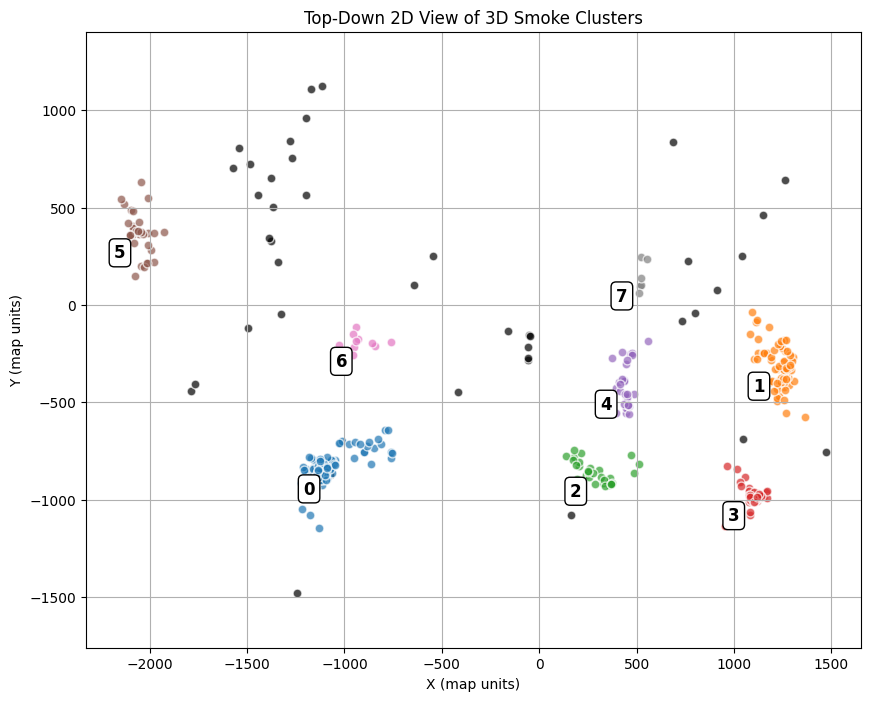

Empty DataFrame
Columns: [antecedents, consequents, support, confidence]
Index: []


In [25]:
main_func("de_ancient", "CT") 

Since there are no smoke setups that passed the thresholds in association rule mining, we cannot do any testing. This means that the smoke setups present either have insufficient instances, low win rate, or both.

## DE_DUST2
### Terrorist Side

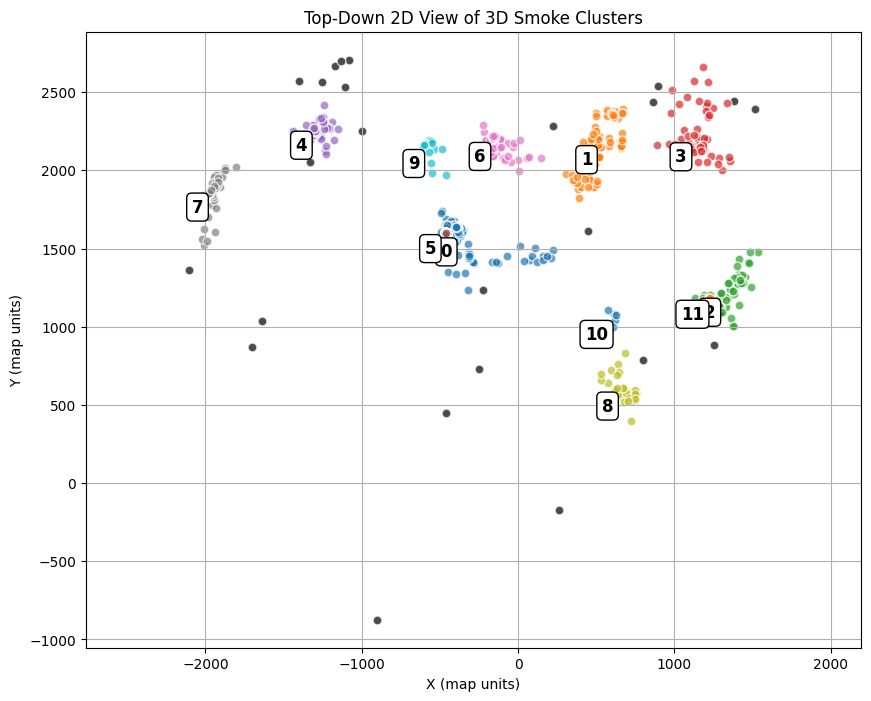

  antecedents consequents   support  confidence
0         (0)       (win)  0.168794    0.595000
1         (3)       (win)  0.093617    0.653465
Antecedent: {0} p = 0.4428
Antecedent: {3} p = 0.0299


In [26]:
main_func("de_dust2", "T")

From the statistics above, we can see that only smoke setup and {3} is the only smoke setup that have been mined based on the criteria, and is statistically significant (p < 0.05). Thus, we can reject the null hypothesis, which suggests that smoke setup {3} is likely to have impact on winning rounds

## DE_DUST2
### Counter-Terrorist Side

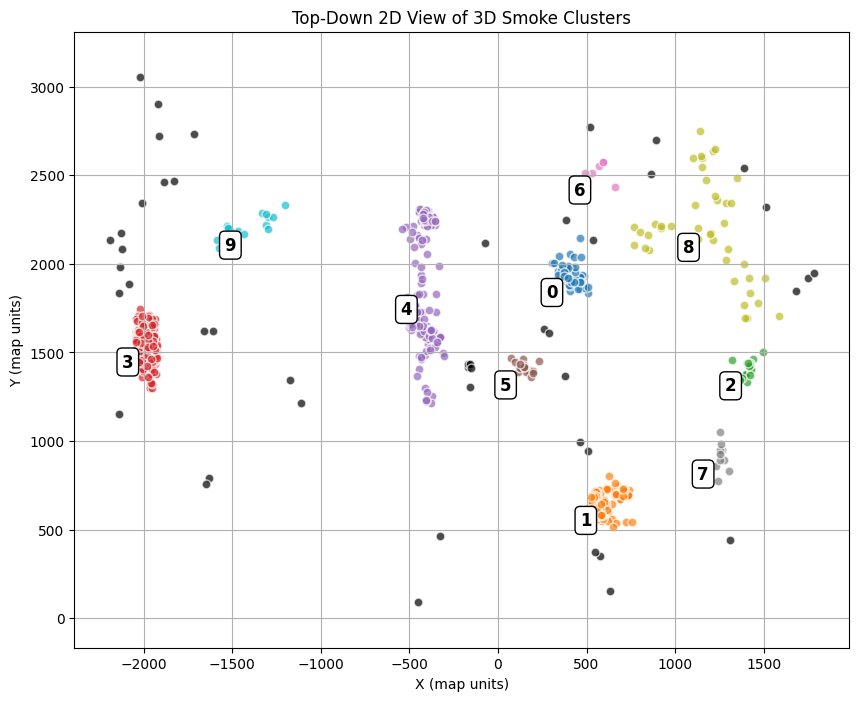

  antecedents consequents   support  confidence
0         (4)       (win)  0.126183     0.56338
Antecedent: {4} p = 0.1241


In [27]:
main_func("de_dust2", "CT")

From the statistics above, we can see that only smoke setup {4} is the only smoke setup that has been mined based on the criteria, however, since the p-value is > 0.05, we fail to reject the null hypothesis. Therefore smoke setup {4} is not likely to have impact on winning rounds.

## DE_MIRAGE
### Terrorist Side

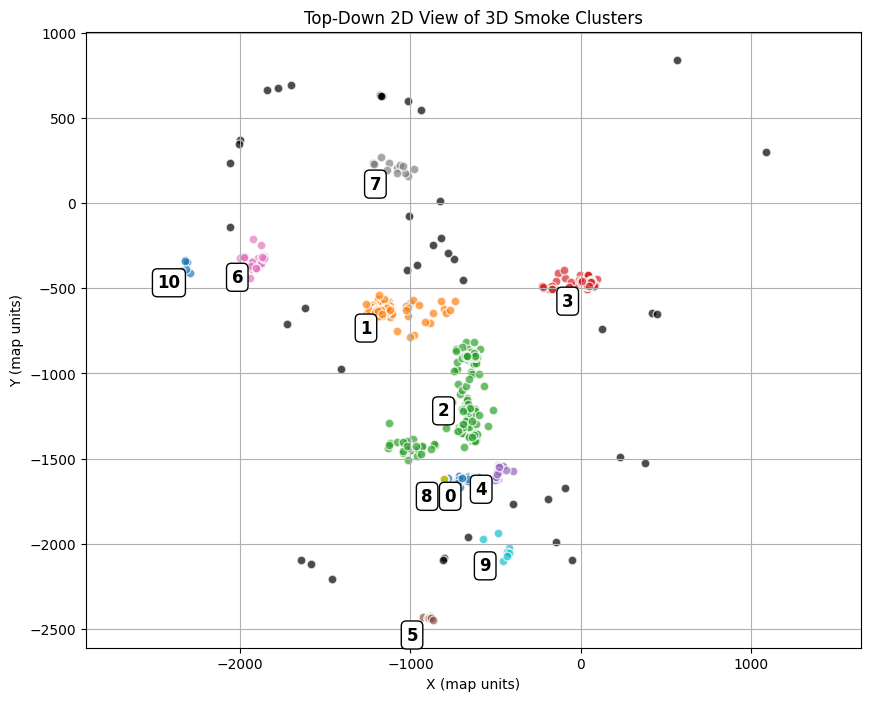

Empty DataFrame
Columns: [antecedents, consequents, support, confidence]
Index: []


In [28]:
main_func("de_mirage", "T")

Since there are no smoke setups that passed the thresholds in association rule mining, we cannot do any testing. This means that the smoke setups present either have insufficient instances, low win rate, or both.

## DE_MIRAGE
### Counter-Terrorist Side

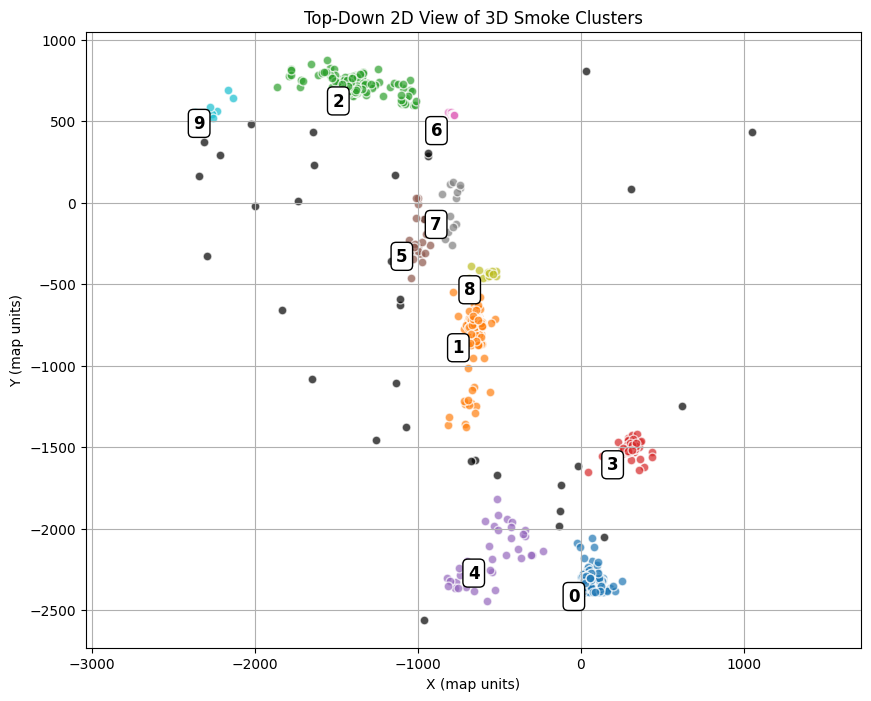

  antecedents consequents   support  confidence
0         (0)       (win)  0.235401    0.658163
1         (1)       (win)  0.235401    0.597222
2         (2)       (win)  0.162409    0.613793
3         (3)       (win)  0.091241    0.581395
Antecedent: {0} p = 0.0060
Antecedent: {1} p = 0.1346
Antecedent: {2} p = 0.5624
Antecedent: {3} p = 0.3004


In [29]:
main_func("de_mirage", "CT")

From the statistics above, we can see that only smoke setup {0} is the only smoke setup that have been mined based on the criteria, and is statistically significant (p < 0.05). Thus, we can reject the null hypothesis, which suggests that smoke setup {0} is likely to have impact on winning rounds.

## DE_NUKE
### Terrorist Side

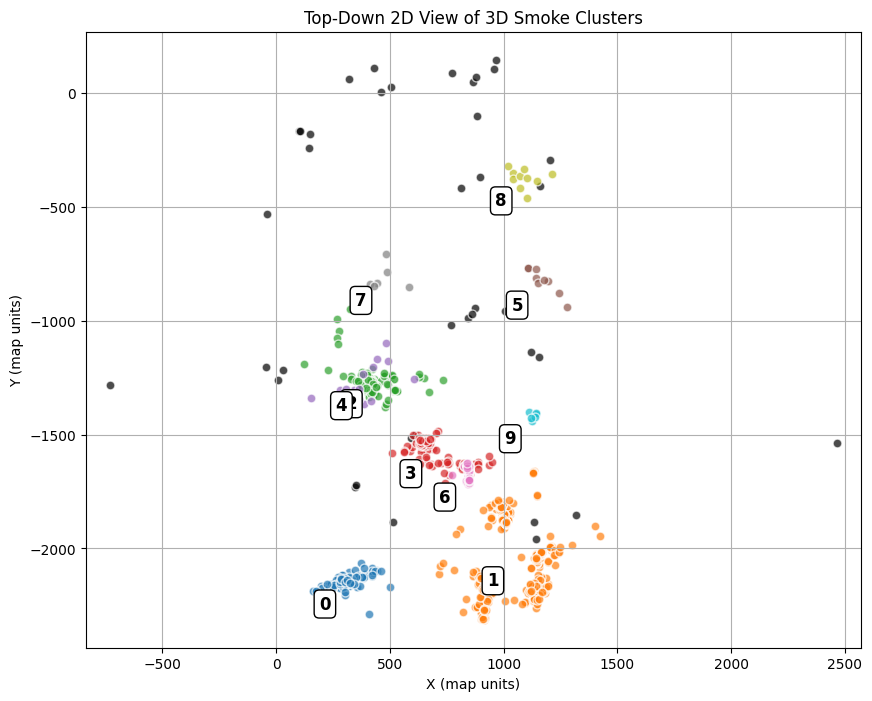

Empty DataFrame
Columns: [antecedents, consequents, support, confidence]
Index: []


In [30]:
main_func("de_nuke", "T")

Since there are no smoke setups that passed the thresholds in association rule mining, we cannot do any testing. This means that the smoke setups present either have insufficient instances, low win rate, or both.

## DE_NUKE
### Counter-Terrorist Side

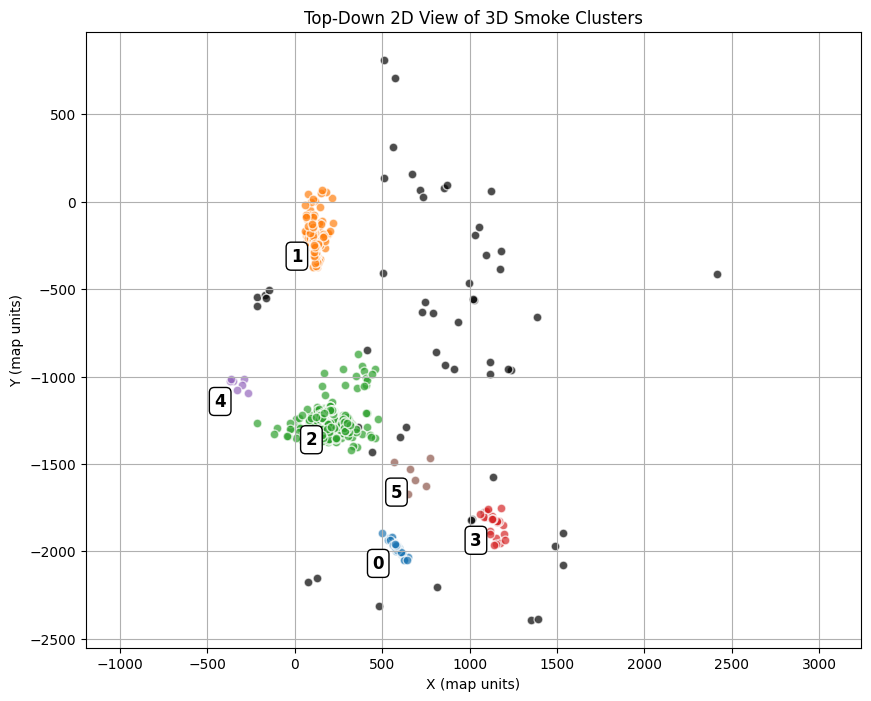

  antecedents consequents   support  confidence
2         (1)       (win)  0.240631    0.580952
6      (1, 2)       (win)  0.145957    0.556391
Antecedent: {1} p = 0.6483
Antecedent: {1, 2} p = 0.6259


In [31]:
main_func("de_nuke", "CT")

From the statistics above, we can see that only smoke setups {1} and {1,2} are the only smoke setups that have been mined based on the criteria, however, since the p-value is > 0.05, we fail to reject the null hypothesis. Therefore smoke setups {1} and {1,2} are not likely to have impact on winning rounds.

## DE_INFERNO
### Terrorist Side

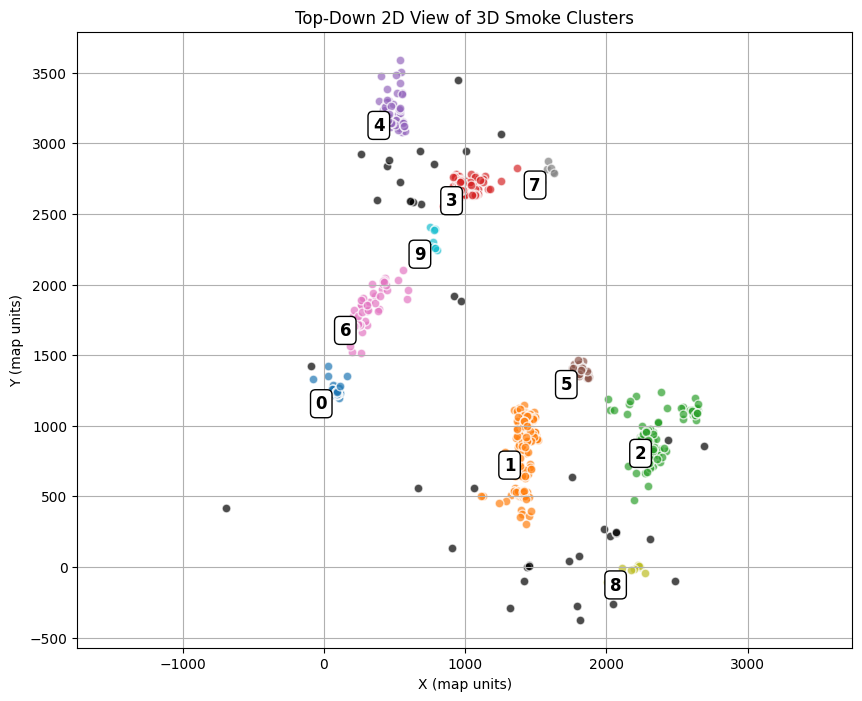

  antecedents consequents   support  confidence
0         (2)       (win)  0.144695    0.620690
1         (3)       (win)  0.160772    0.632911
Antecedent: {2} p = 0.0526
Antecedent: {3} p = 0.0000


In [32]:
main_func("de_inferno", "T")

From the statistics above, we can see that only smoke setup {3} is the only smoke setup that have been mined based on the criteria, and is statistically significant (p < 0.05). Thus, we can reject the null hypothesis, which suggests that smoke setup {3} is likely to have impact on winning rounds.

## DE_INFERNO
### Counter-Terrorist Side

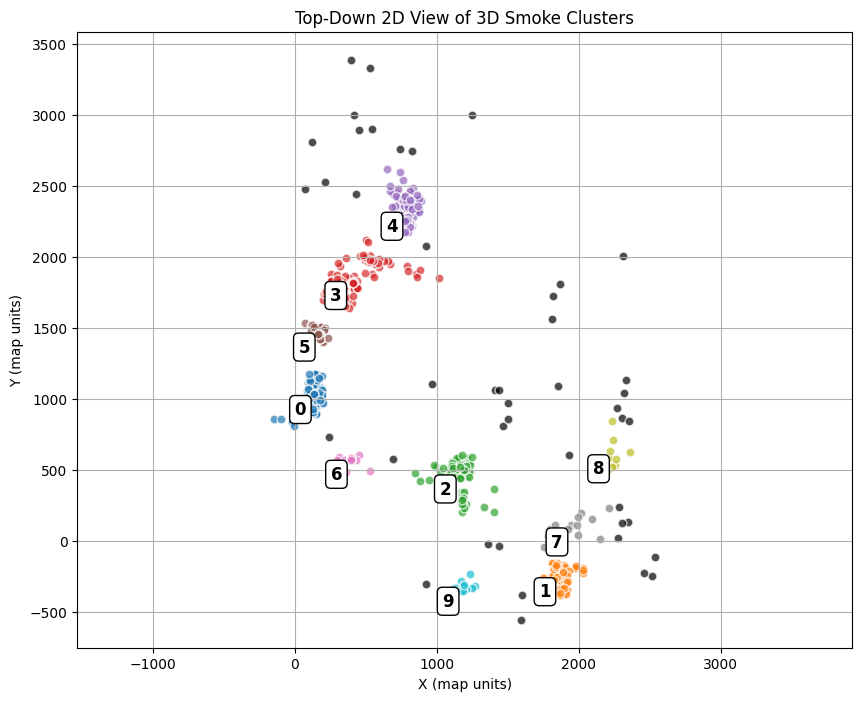

  antecedents consequents   support  confidence
0         (0)       (win)  0.169841    0.656442
1         (1)       (win)  0.107937    0.586207
2         (2)       (win)  0.107937    0.623853
Antecedent: {0} p = 0.0985
Antecedent: {1} p = 0.1013
Antecedent: {2} p = 0.0136


In [33]:
main_func("de_inferno", "CT")

From the statistics above, we can see that only smoke setup {2} is the only smoke setup that have been mined based on the criteria, and is statistically significant (p < 0.05). Thus, we can reject the null hypothesis, which suggests that smoke setup {2} is likely to have impact on winning rounds.

## DE_ANUBIS
### Terrorist Side

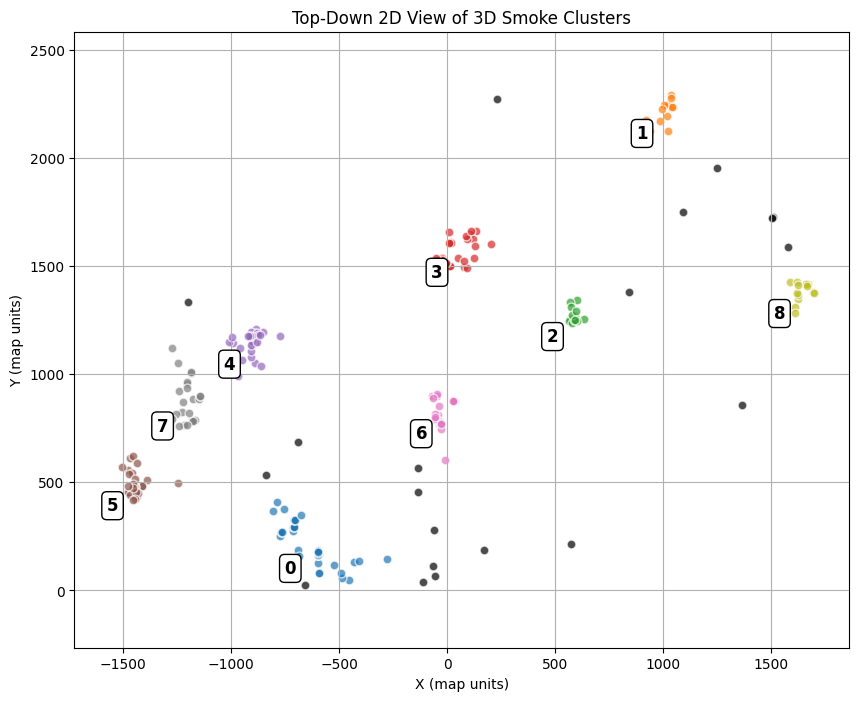

  antecedents consequents   support  confidence
1         (0)       (win)  0.161677    0.600000
2         (4)       (win)  0.119760    0.666667
3         (6)       (win)  0.095808    0.615385
4         (7)       (win)  0.113772    0.655172
Antecedent: {0} p = 0.1544
Antecedent: {4} p = 0.0156
Antecedent: {6} p = 0.1444
Antecedent: {7} p = 0.0188


In [34]:
main_func("de_anubis", "T")

From the statistics above, we can see that only smoke setup {4} and {7} are the only smoke setups that have been mined based on the criteria, and is statistically significant (p < 0.05). Thus, we can reject the null hypothesis, which suggests that smoke setup {4} and {7} are likely to have impact on winning rounds

## DE_ANUBIS
### Counter-Terrorist Side

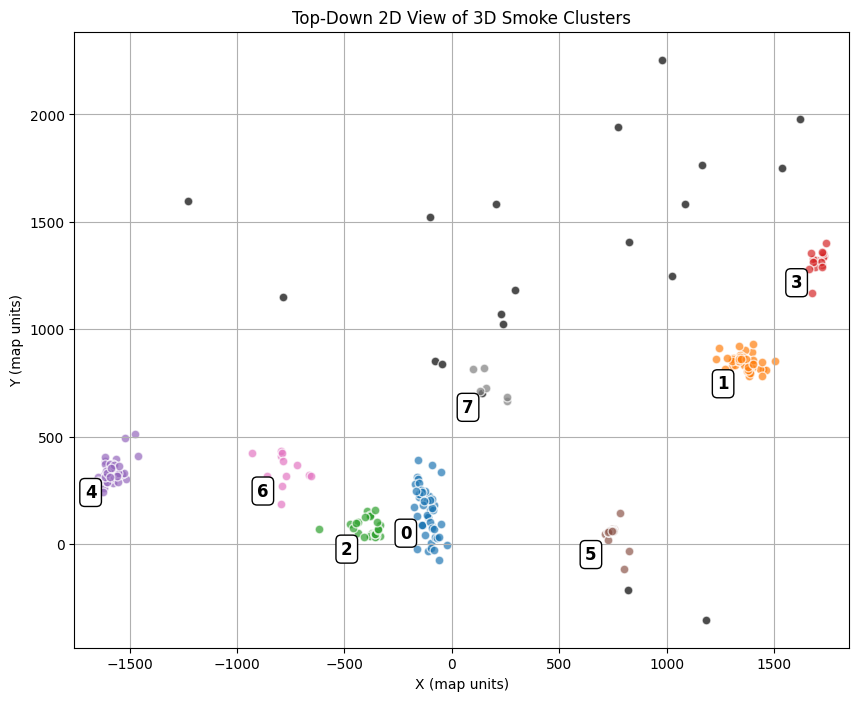

  antecedents consequents   support  confidence
0         (1)       (win)  0.141104    0.560976
Antecedent: {1} p = 0.1584


In [35]:
main_func("de_anubis", "CT")

From the statistics above, we can see that only smoke setup {1} is the only smoke setup that have been mined based on the criteria, however, since the p-value is > 0.05, we fail to reject the null hypothesis. Therefore smoke setup {1} is not likely to have impact on winning rounds.

## DE_TRAIN
### Terrorist Side

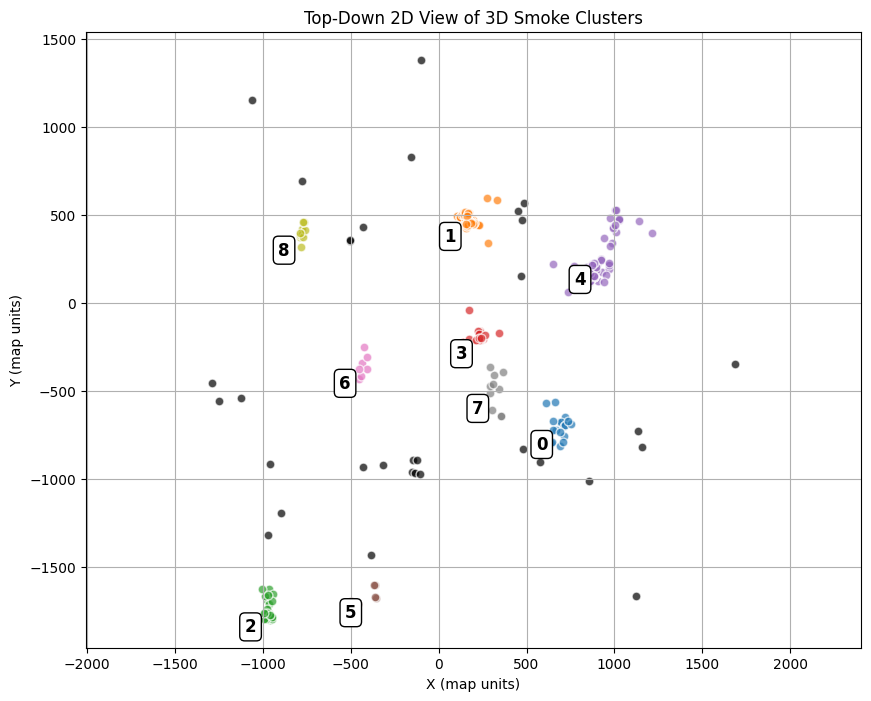

  antecedents consequents   support  confidence
1         (1)       (win)  0.261438    0.615385
2         (2)       (win)  0.104575    0.571429
4         (3)       (win)  0.091503    0.560000
5         (4)       (win)  0.261438    0.666667
7      (1, 2)       (win)  0.098039    0.576923
Antecedent: {1} p = 0.7299
Antecedent: {2} p = 0.6967
Antecedent: {3} p = 0.8398
Antecedent: {4} p = 0.1979
Antecedent: {1, 2} p = 0.7663


In [36]:
main_func("de_train", "T")

From the statistics above, we can see that only smoke setups {1}, {2}, {3}, {4} and {1,2} are the only smoke setups that have been mined based on the criteria, however, since the p-value is > 0.05, we fail to reject the null hypothesis. Therefore smoke setups {1}, {2}, {3},{4} and {1,2} are not likely to have impact on winning rounds.

## DE_TRAIN
### Counter-Terrorist Side

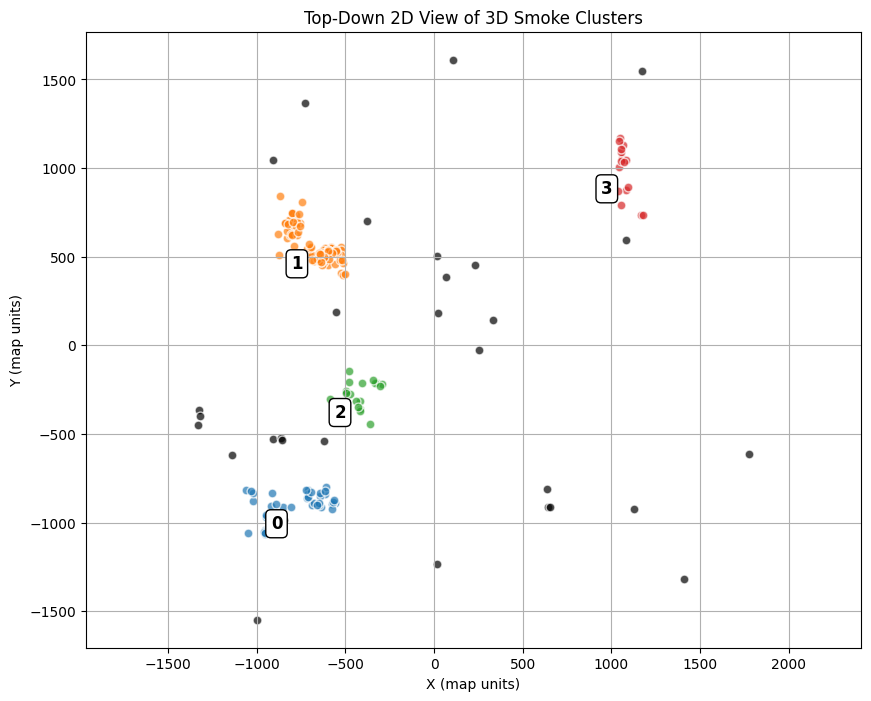

Empty DataFrame
Columns: [antecedents, consequents, support, confidence]
Index: []


In [37]:
main_func("de_train", "CT")

Since there are no smoke setups that passed the thresholds in association rule mining, we cannot do any testing. This means that the smoke setups present either have insufficient instances, low win rate, or both.

## Conclusion

To conclude, there are certain sides in certain maps that have a smoke setup that is strongly associated with winning rounds. It can be said that these setups can be considered a winning "meta" for the associated sides and maps. 

Although only a few smoke setups are considered to pass through the rule mining threshold and the test of independence, there are still benefits in just knowing the cluster of smokes. This information can be used as a basis of the "meta" setup since these clusters are where smoke grenades are thrown into more often than not. Even if you do not know its association to win rate or any other statistic, it is still useful in determining areas to take note of when defending or attacking a site. After all, smokes in CS2 can go both ways: as means of defense or as means of attack. 

While there are certain smoke setups in certain maps that have a likely association with winning rounds, it is important to remember that this is not a causation. You will not get an automatic +N% winrate just because you threw a smoke grenade in the aforementioned smoke setup areas/clusters. CS2 is a complicated game, with an even more complicated player base. There might be more factors that impacts wins more heavily than smoke setups do. 



Amiruzzaman, M., Rahman, R., Islam, M. R., & Nor, R. M. (2022, June 27). Logical analysis of built‑in DBSCAN functions in popular data science programming      
    languages. OSF Preprints. https://doi.org/10.31219/osf.io/ge654